Reference: Molecular Similarity-Based Domain Applicability Metric Efficiently Identifies Out-of-Domain Compounds

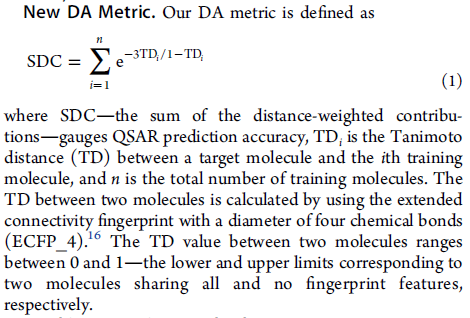

In [1]:
from IPython.display import Image
Image("da_metric.PNG")

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import oddt
from oddt.fingerprints import ECFP
import numpy as np

In [3]:
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(font_scale=2)
sns.set_context("paper", font_scale= 2, rc={"lines.linewidth": 2})

In [38]:
# mols = oddt.toolkit.readfile('smi', 'data/test_smiles.smi')

In [39]:
smiles = []

with open("data/test_smiles.smi") as f:
    for line in f.read().splitlines():
        if line:
            smiles.append(line)

# Convert into Canonical SMILES
smiles = [Chem.CanonSmiles(s) for s in smiles]

train_smiles = smiles[:-50]
test_smiles = smiles[-50:]

In [40]:
class AD:
    def __init__(self, train_data):
        if not isinstance(train_data, list) or not train_data or len(train_data) < 10:
            raise Exception("Training data should be a list of at least 10 SMILES")
        
        # Canonicalize the SMILES
        self.train_data = [Chem.CanonSmiles(sm) for sm in smiles if len(sm) > 0]
        self.fingerprints = []
    
    def fit(self):
        # Find the fingerprints
        for sm in self.train_data:
            mol = Chem.MolFromSmiles(sm)
            if not mol:
                continue
            self.fingerprints.append(AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2))
            
        if len(self.fingerprints) < 5:
            raise Exception(f"Not enough fingerprints can be generated from the training data (len={len(self.fingerprints)})")
    
    def get_score(self, smiles):
        if not self.fingerprints:
            raise Exception("Please run fit() first.")
            
        smiles = Chem.CanonSmiles(smiles)
        mol = Chem.MolFromSmiles(smiles)
        
        if not mol:
            raise Exception("Invalid SMILES.")
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius = 2)
        scores = []
        
        for train_fp in self.fingerprints:
            scores.append(DataStructs.TanimotoSimilarity(train_fp, fp))
        
        scores = np.array(scores)
        return np.sum(np.exp(-1 * (3 * scores) / (1 - scores)))

## Example

In [41]:
from glob import glob
import pandas as pd

In [42]:
smiles_file = 'data/3CL/3CL-balanced_randomsplit7_70_15_15_'
train_smiles = pd.read_csv(smiles_file + 'tr.csv', usecols=[4, 161])
test_smiles = pd.read_csv(smiles_file + 'te.csv', usecols = [4, 161])
valid_smiles = pd.read_csv(smiles_file + 'va.csv', usecols = [4, 161])

In [43]:
result_df = pd.read_csv("../redial-2020/redial-2020-notebook-work/valid_test_csv_pred_cons/test/3CL_te.csv")
result_df.head()

,MOL.ID,DC.ID,SMILES_stand,InChI,SMILES,DC.NAME,NCATS.SYNONYMS,NCGC.ID,WARNING,3CL.SIGNIFICANCE,...,rdkDescriptors_pred_label,rdkDescriptors_pred_prob,pharmacophore_pred_label,pharmacophore_pred_prob,volsurf_pred_label,volsurf_pred_prob,Consensus_label,Consensus_prob_label,Consensus_volsurf_label,Consensus_volsurf_prob_label
0,MOL1591,2505.0,N=C(N)NS(=O)(=O)c1ccc(N)cc1,"InChI=1S/C7H10N4O2S/c8-5-1-3-6(4-2-5)14(12,13)...",N=C(N)NS(=O)(=O)c1ccc(N)cc1,sulfaguanidine,Sulfaguanidine,NaN,NaN,INACTIVE,...,1.0,0.755638,1.0,0.60,0.0,0.47,1.0,1.0,1.0,1.0
1,MOL8294,NaN,CCO[C@@H]1OC(=O)C[C@@H]1NC(=O)[C@@H]1CCCN2C(=O...,InChI=1S/C26H29N5O7/c1-2-37-26-18(14-21(33)38-...,CCO[C@@H]1OC(=O)C[C@@H]1NC(=O)[C@@H]1CCCN2C(=O...,NaN,NaN,NCGC00384474-01,NaN,INACTIVE,...,0.0,0.097816,0.0,0.37,0.0,0.49,0.0,0.0,0.0,0.0
2,MOL585,961.0,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,InChI=1S/C22H24N2O8/c1-7-8-5-4-6-9(25)11(8)16(...,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,doxycycline,Doxycycline,"NCGC00261090-01, NCGC00161602-13, NCGC00161602...",NaN,LOW,...,1.0,0.713220,1.0,0.89,1.0,0.73,1.0,1.0,1.0,1.0
3,MOL5604,NaN,C[C@]12CC[C@H]3[C@@H](CC[C@H]4C[C@H](O)CC[C@@]...,InChI=1S/C19H29BrO2/c1-18-7-5-12(21)9-11(18)3-...,C[C@]12CC[C@H]3[C@@H](CC[C@H]4C[C@H](O)CC[C@@]...,NaN,NaN,NCGC00485518-01,NaN,INACTIVE,...,1.0,0.756001,1.0,0.56,1.0,0.54,1.0,1.0,1.0,1.0
4,MOL9252,NaN,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,InChI=1S/C30H48O4/c1-25(2)12-14-30(24(33)34)15...,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,NaN,NaN,NCGC00385682-01,NaN,INACTIVE,...,1.0,0.957856,1.0,0.64,0.0,0.50,1.0,1.0,1.0,1.0


In [44]:
tp_mask = result_df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 1, axis = 1)
tn_mask = result_df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 0, axis = 1)
fp_mask = result_df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 1, axis = 1)
fn_mask = result_df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 0, axis = 1)

In [45]:
confusion_matrix(result_df.Label, result_df.fingerprint_pred_label)

array([[27, 16],
       [20, 24]])

In [46]:
test_smiles = test_smiles[test_smiles.SMILES.isin(result_df.SMILES)]

In [47]:
train_smiles_actives = train_smiles.Label.apply(lambda x: True if x == 1 else False)
test_smiles_actives = test_smiles.Label.apply(lambda x: True if x == 1 else False)
valid_smiles_actives = valid_smiles.Label.apply(lambda x: True if x == 1 else False)

In [48]:
train_smiles.head()

,SMILES,Label
0,COc1cc2c(c(OC)c1OC)-c1ccc(SC)c(=O)cc1[C@@H](NC...,0
1,COc1nc(OCc2cccc(-c3ccccc3)c2C)ccc1CNCCNC(C)=O,1
2,OCC(S)CS,1
3,COc1ccc(C2(C#N)CCC(C(=O)O)CC2)cc1OC1CCCC1,0
4,CC1(C)O[C@@H]2CO[C@@]3(COS(N)(=O)=O)OC(C)(C)O[...,1


In [49]:
ad = AD(train_data=train_smiles.SMILES.to_list())
ad.fit()

In [50]:
sdc_scores_test = np.array(test_smiles.SMILES.apply(lambda x: ad.get_score(x)))
sdc_scores_train = np.array(train_smiles.SMILES.apply(lambda x: ad.get_score(x)))
sdc_scores_valid = np.array(valid_smiles.SMILES.apply(lambda x: ad.get_score(x)))

In [51]:
train_actives = sdc_scores_train[train_smiles_actives]
train_nactives = sdc_scores_train[~train_smiles_actives]
test_actives = sdc_scores_test[test_smiles_actives]
test_nactives = sdc_scores_test[~test_smiles_actives]
valid_actives = sdc_scores_valid[valid_smiles_actives]
valid_nactives = sdc_scores_valid[~valid_smiles_actives]

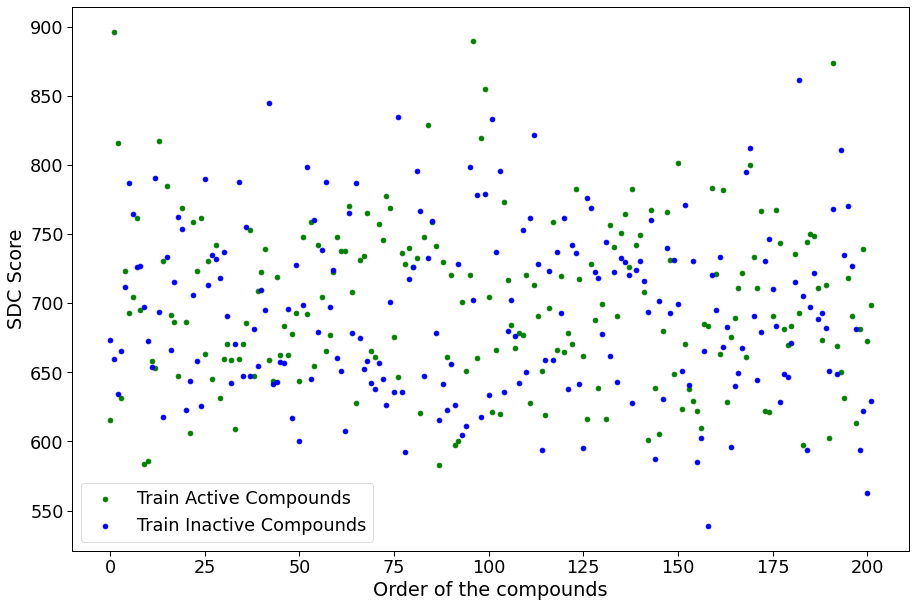

In [52]:
plt.figure(figsize=(15, 10))
plt.scatter(range(len(train_actives)), train_actives, color='green', label = "Train Active Compounds")
plt.scatter(range(len(train_nactives)), train_nactives, color='blue', label = "Train Inactive Compounds")
plt.xlabel("Order of the compounds")
plt.ylabel("SDC Score")
plt.legend()
plt.show()

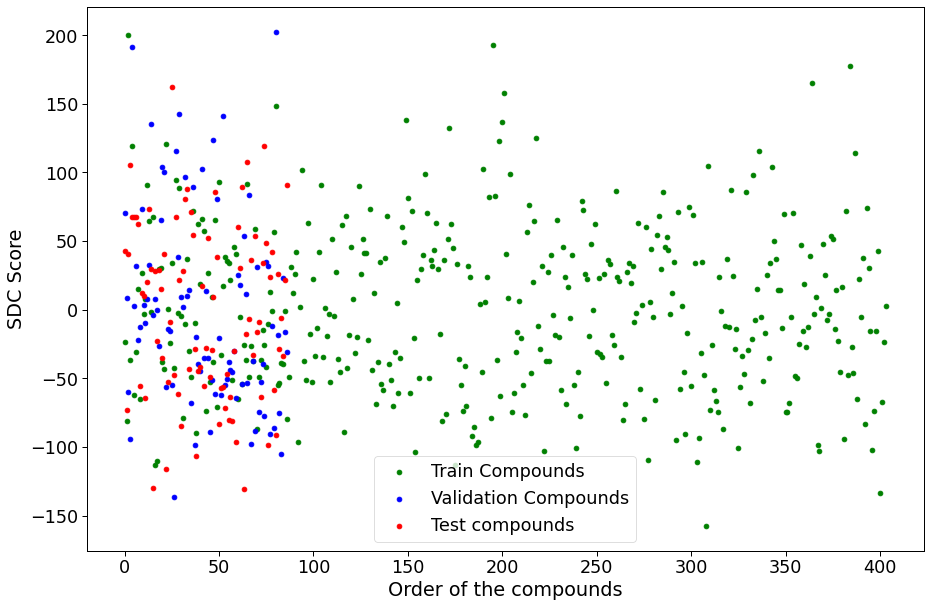

In [53]:
plt.figure(figsize=(15, 10))
plt.scatter(range(len(sdc_scores_train)), sdc_scores_train-np.mean(sdc_scores_train), color='green', label = "Train Compounds")
plt.scatter(range(len(sdc_scores_valid)), sdc_scores_valid-np.mean(sdc_scores_train), color='blue', label = "Validation Compounds")
plt.scatter(range(len(sdc_scores_test)), sdc_scores_test-np.mean(sdc_scores_train), color='red', label = "Test compounds")
plt.xlabel("Order of the compounds")
plt.ylabel("SDC Score")
plt.legend()
plt.show()

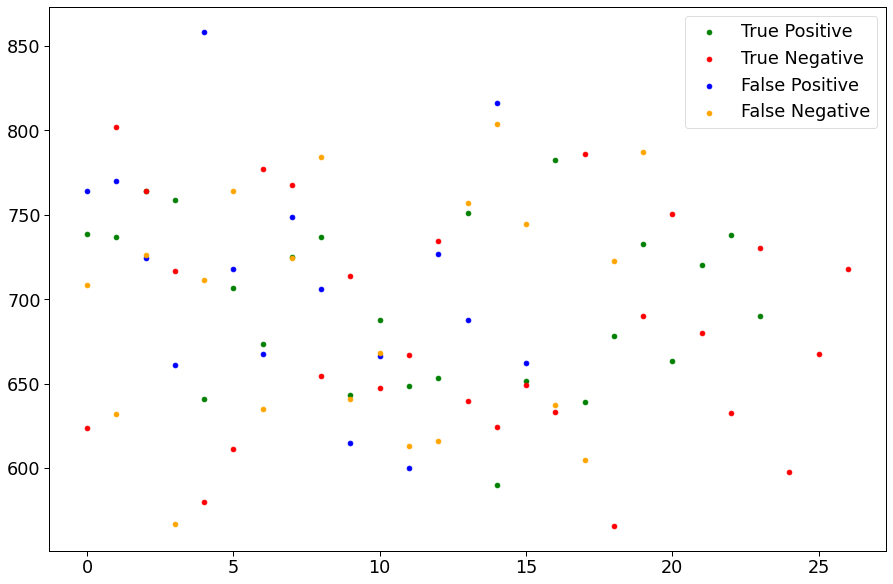

In [54]:
plt.figure(figsize=(15, 10))
# plt.scatter(range(len(sdc_scores_test)), sdc_scores_test, color = 'black', label = "Test Compounds")
plt.scatter(range(len(sdc_scores_test[tp_mask])), sdc_scores_test[tp_mask], color = 'green', label = "True Positive")
plt.scatter(range(len(sdc_scores_test[tn_mask])), sdc_scores_test[tn_mask], color = 'red', label = "True Negative")
plt.scatter(range(len(sdc_scores_test[fp_mask])), sdc_scores_test[fp_mask], color = 'blue', label = "False Positive")
plt.scatter(range(len(sdc_scores_test[fn_mask])), sdc_scores_test[fn_mask], color = 'orange', label = "False Negative")
plt.legend()
plt.show()

In [55]:
result_df.head()

,MOL.ID,DC.ID,SMILES_stand,InChI,SMILES,DC.NAME,NCATS.SYNONYMS,NCGC.ID,WARNING,3CL.SIGNIFICANCE,...,rdkDescriptors_pred_label,rdkDescriptors_pred_prob,pharmacophore_pred_label,pharmacophore_pred_prob,volsurf_pred_label,volsurf_pred_prob,Consensus_label,Consensus_prob_label,Consensus_volsurf_label,Consensus_volsurf_prob_label
0,MOL1591,2505.0,N=C(N)NS(=O)(=O)c1ccc(N)cc1,"InChI=1S/C7H10N4O2S/c8-5-1-3-6(4-2-5)14(12,13)...",N=C(N)NS(=O)(=O)c1ccc(N)cc1,sulfaguanidine,Sulfaguanidine,NaN,NaN,INACTIVE,...,1.0,0.755638,1.0,0.60,0.0,0.47,1.0,1.0,1.0,1.0
1,MOL8294,NaN,CCO[C@@H]1OC(=O)C[C@@H]1NC(=O)[C@@H]1CCCN2C(=O...,InChI=1S/C26H29N5O7/c1-2-37-26-18(14-21(33)38-...,CCO[C@@H]1OC(=O)C[C@@H]1NC(=O)[C@@H]1CCCN2C(=O...,NaN,NaN,NCGC00384474-01,NaN,INACTIVE,...,0.0,0.097816,0.0,0.37,0.0,0.49,0.0,0.0,0.0,0.0
2,MOL585,961.0,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,InChI=1S/C22H24N2O8/c1-7-8-5-4-6-9(25)11(8)16(...,C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...,doxycycline,Doxycycline,"NCGC00261090-01, NCGC00161602-13, NCGC00161602...",NaN,LOW,...,1.0,0.713220,1.0,0.89,1.0,0.73,1.0,1.0,1.0,1.0
3,MOL5604,NaN,C[C@]12CC[C@H]3[C@@H](CC[C@H]4C[C@H](O)CC[C@@]...,InChI=1S/C19H29BrO2/c1-18-7-5-12(21)9-11(18)3-...,C[C@]12CC[C@H]3[C@@H](CC[C@H]4C[C@H](O)CC[C@@]...,NaN,NaN,NCGC00485518-01,NaN,INACTIVE,...,1.0,0.756001,1.0,0.56,1.0,0.54,1.0,1.0,1.0,1.0
4,MOL9252,NaN,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,InChI=1S/C30H48O4/c1-25(2)12-14-30(24(33)34)15...,CC1(C)CC[C@]2(C(=O)O)CC[C@]3(C)C(=CCC4[C@@]5(C...,NaN,NaN,NCGC00385682-01,NaN,INACTIVE,...,1.0,0.957856,1.0,0.64,0.0,0.50,1.0,1.0,1.0,1.0


In [56]:
result_df['sdc'] = result_df.SMILES.apply(lambda x: ad.get_score(x))
result_df['preds'] = ''
result_df['preds'][fn_mask] = 'fn'
result_df['preds'][fp_mask] = 'fp'
result_df['preds'][tn_mask] = 'tn'
result_df['preds'][tp_mask] = 'tp'

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/panda

<AxesSubplot:title={'center':'sdc'}, xlabel='preds'>

<Figure size 1080x720 with 0 Axes>

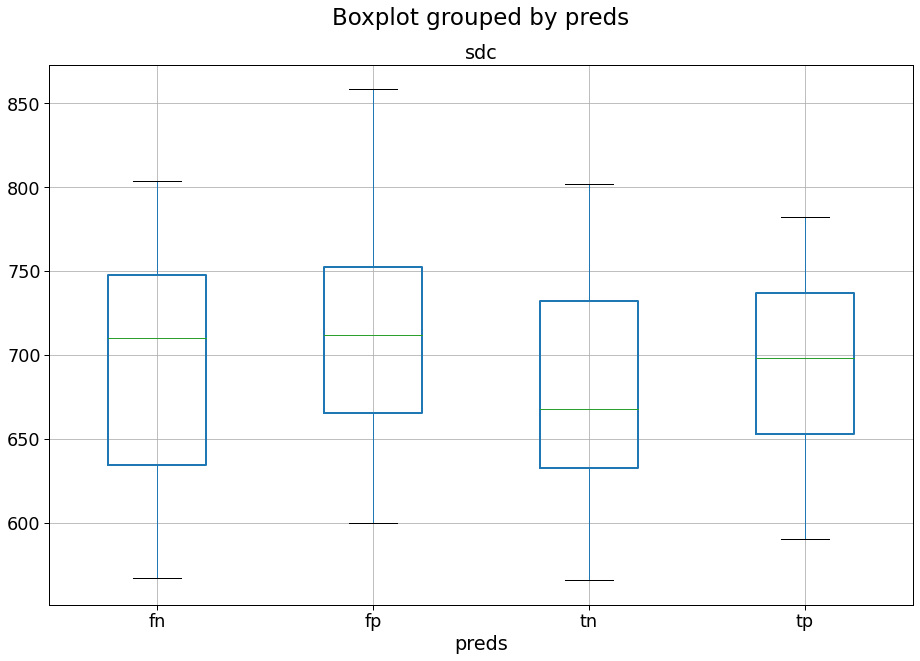

In [57]:
plt.figure(figsize = (15, 10))
result_df.boxplot(by = 'preds', column='sdc', figsize=(15, 10), boxprops = dict(linewidth = 2))

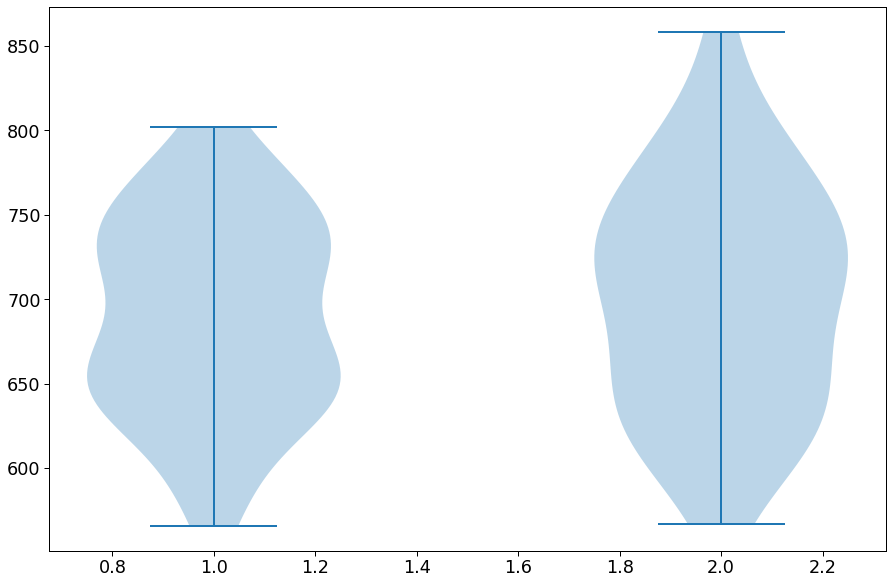

In [58]:
fig, axs = plt.subplots(figsize = (15, 10))
axs.violinplot(dataset = [result_df[(result_df.preds == 'tp') | (result_df.preds == 'tn')]['sdc'].values,
                         result_df[(result_df.preds == 'fp') | (result_df.preds == 'fn')]['sdc'].values])

plt.show()

In [59]:
from sklearn import metrics

In [60]:
# probs = result_df.fingerprint_pred_prob.tolist()
# preds = result_df.fingerprint_pred_label.tolist()
# fpr, tpr, threshold = metrics.roc_curve(result_df.Label.tolist(), preds)
# roc_auc = metrics.auc(fpr, tpr)

# # method I: plt
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

# # # method II: ggplot
# # from ggplot import *
# # df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# # ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

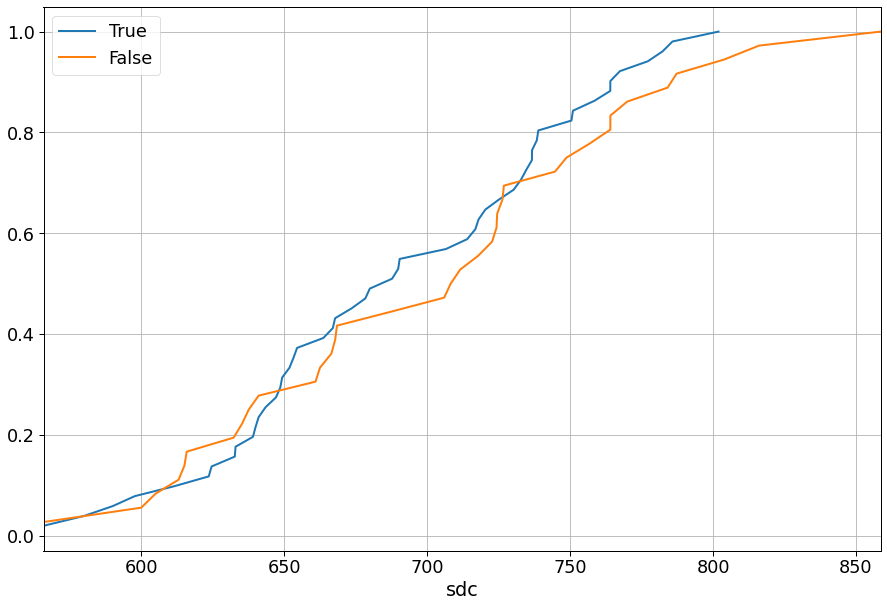

In [61]:
# Get the frequency, PDF and CDF for each value in the series (Correct predictions)

s = result_df[tp_mask | tn_mask]['sdc']
df = pd.DataFrame(s)
stats_tdf = df.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

# PDF
stats_tdf['pdf'] = stats_tdf['frequency'] / sum(stats_tdf['frequency'])

# CDF
stats_tdf['cdf'] = stats_tdf['pdf'].cumsum()
stats_tdf = stats_tdf.reset_index()

# Get the frequency, PDF and CDF for each value in the series (Wrong predictions)

s = result_df[fp_mask | fn_mask]['sdc']
df = pd.DataFrame(s)
stats_fdf = df.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

# PDF
stats_fdf['pdf'] = stats_fdf['frequency'] / sum(stats_fdf['frequency'])

# CDF
stats_fdf['cdf'] = stats_fdf['pdf'].cumsum()
stats_fdf = stats_fdf.reset_index()

fig, axs = plt.subplots(figsize = (15, 10))
stats_tdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['True'], ax = axs)
stats_fdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['False'], ax = axs)
plt.legend()
plt.show()

In [63]:
import os

### Generating CDF plots for training data prediction

In [67]:
from glob import glob
pred_files = glob("/data2/mhassan/redial-2020/redial-2020-notebook-work/valid_test_csv_pred_cons/train/*.csv")

for f in pred_files:
    filename = os.path.split(f)[1]
    df = pd.read_csv(f)
    ad = AD(train_data=df.SMILES.to_list())
    ad.fit()
    df['sdc'] = df.SMILES.apply(lambda x: ad.get_score(x))
        
    tp_mask = df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 1, axis = 1)
    tn_mask = df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 0, axis = 1)
    fp_mask = df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 1, axis = 1)
    fn_mask = df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 0, axis = 1)

    df['preds'] = ''
    df['preds'][fn_mask] = 'fn'
    df['preds'][fp_mask] = 'fp'
    df['preds'][tn_mask] = 'tn'
    df['preds'][tp_mask] = 'tp'

    # Get the frequency, PDF and CDF for each value in the series (Correct predictions)

    s = df[tp_mask | tn_mask]['sdc']
    dft = pd.DataFrame(s)
    stats_tdf = dft.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

    # PDF
    stats_tdf['pdf'] = stats_tdf['frequency'] / sum(stats_tdf['frequency'])

    # CDF
    stats_tdf['cdf'] = stats_tdf['pdf'].cumsum()
    stats_tdf = stats_tdf.reset_index()

    # Get the frequency, PDF and CDF for each value in the series (Wrong predictions)

    s = df[fp_mask | fn_mask]['sdc']
    dff = pd.DataFrame(s)
    stats_fdf = dff.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

    # PDF
    stats_fdf['pdf'] = stats_fdf['frequency'] / sum(stats_fdf['frequency'])

    # CDF
    stats_fdf['cdf'] = stats_fdf['pdf'].cumsum()
    stats_fdf = stats_fdf.reset_index()

    fig, axs = plt.subplots(figsize = (15, 10))
    stats_tdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['True'], ax = axs)
    try:
        stats_fdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['False'], ax = axs)
    except:
        print("can't plot")
    plt.legend()
    plt.title('CDF plot on training data (' + filename[:-7] + ')')
    plt.savefig("./plots/cdf/train/" + filename + ".png", dpi = 300)
    plt.close(fig)
    #plt.show()
#     break

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/si

can't plot


/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/si

can't plot


/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/si

can't plot


/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/si

### Generating CDF plots for test data prediction

In [78]:
items = ['3CL', 
         'CoV1-PPE_cs', 
         'cytotox', 
         'MERS-PPE', 
         'ACE2', 
         'CoV1-PPE', 
         'hCYTOX', 
         'TruHit', 
         'AlphaLISA', 
         'CPE', 
         'MERS-PPE']

In [80]:
for item in items:
    csv_file = f"/data2/mhassan/redial-2020/redial-2020-notebook-work/valid_test_csv_pred_cons/test/{item}_te.csv"
    if not os.path.isfile(csv_file):
        print(f"{item} not found")

In [82]:
for item in items:
    train_file = f"/data2/mhassan/redial-2020/redial-2020-notebook-work/valid_test_csv_pred_cons/train/{item}_tr.csv"
    test_file = f"/data2/mhassan/redial-2020/redial-2020-notebook-work/valid_test_csv_pred_cons/test/{item}_te.csv"
    train_df = pd.read_csv(train_file)
    df = pd.read_csv(test_file)
    ad = AD(train_data=train_df.SMILES.to_list())
    ad.fit()
    df['sdc'] = df.SMILES.apply(lambda x: ad.get_score(x))
        
    tp_mask = df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 1, axis = 1)
    tn_mask = df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 0, axis = 1)
    fp_mask = df.apply(lambda x: x['Label'] == 0 and x['fingerprint_pred_label'] == 1, axis = 1)
    fn_mask = df.apply(lambda x: x['Label'] == 1 and x['fingerprint_pred_label'] == 0, axis = 1)

    df['preds'] = ''
    df['preds'][fn_mask] = 'fn'
    df['preds'][fp_mask] = 'fp'
    df['preds'][tn_mask] = 'tn'
    df['preds'][tp_mask] = 'tp'

    # Get the frequency, PDF and CDF for each value in the series (Correct predictions)

    s = df[tp_mask | tn_mask]['sdc']
    dft = pd.DataFrame(s)
    stats_tdf = dft.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

    # PDF
    stats_tdf['pdf'] = stats_tdf['frequency'] / sum(stats_tdf['frequency'])

    # CDF
    stats_tdf['cdf'] = stats_tdf['pdf'].cumsum()
    stats_tdf = stats_tdf.reset_index()

    # Get the frequency, PDF and CDF for each value in the series (Wrong predictions)

    s = df[fp_mask | fn_mask]['sdc']
    dff = pd.DataFrame(s)
    stats_fdf = dff.groupby('sdc')['sdc'].agg('count').pipe(pd.DataFrame).rename(columns = {'sdc': 'frequency'})

    # PDF
    stats_fdf['pdf'] = stats_fdf['frequency'] / sum(stats_fdf['frequency'])

    # CDF
    stats_fdf['cdf'] = stats_fdf['pdf'].cumsum()
    stats_fdf = stats_fdf.reset_index()

    fig, axs = plt.subplots(figsize = (15, 10))
    stats_tdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['True'], ax = axs)
    try:
        stats_fdf.plot(x = 'sdc', y = ['cdf'], grid = True, label = ['False'], ax = axs)
    except:
        print("can't plot")
    plt.legend()
    plt.title(f"CDF plot on test data ({item})")
    plt.savefig(f"./plots/cdf/test/{item}.png", dpi = 300)
    plt.close(fig)
    #plt.show()
#     break

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/minicon

/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhassan/minicon